In [1]:
import os
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../src")
import exlib

/home/antonxue/lib/miniconda3/envs/exlib/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = exlib.datasets.cholec.CholecDataset(split="test")

In [3]:
# Change the index until you don't wanna throw up
item = dataset[2]

In [4]:
# Apply blurring
blur_filter = torchvision.transforms.GaussianBlur(7, 10.0)

blur_and_gray_filter = torchvision.transforms.Compose([
    blur_filter,
    torchvision.transforms.Grayscale()
])

resize = torchvision.transforms.Resize((256,256))

raw_image = resize(item["image"])
blr_image = blur_and_gray_filter(raw_image)

<Figure size 640x480 with 0 Axes>

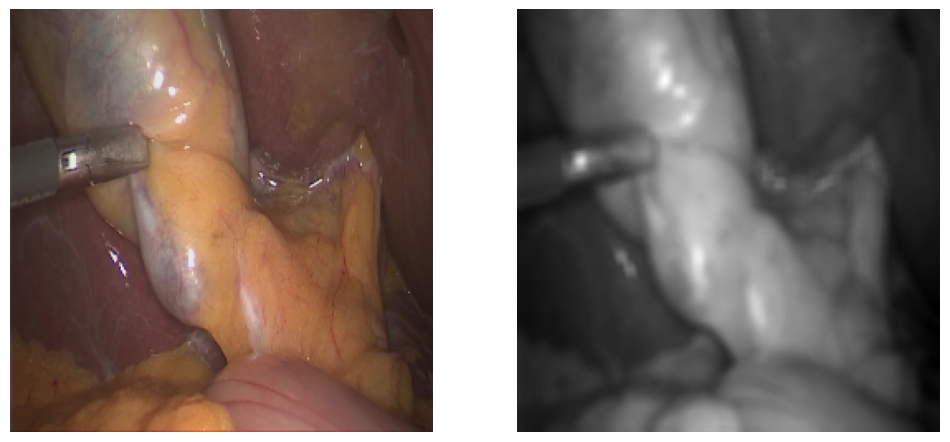

In [5]:
# Test image quality
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(12,8))
for a in ax: a.set_axis_off()
ax[0].imshow(raw_image.numpy().transpose(1,2,0))

# ax[1].imshow(blr_image.numpy().transpose(1,2,0))
ax[1].imshow(blr_image.numpy().transpose(1,2,0), cmap="gray")

# If the above looks okay, THEN proceed

In [6]:
# Expert integer-valued labels (H,W) and binary-valued masks (num_masks,H,W)
gng_labels = resize(item["gonogo"][None,...])[0]
gng_masks = F.one_hot(gng_labels).permute(2,0,1)
gng_masked_raw_image = gng_masks.unsqueeze(1) * raw_image.unsqueeze(0)
gng_masked_blr_image = gng_masks.unsqueeze(1) * blr_image.unsqueeze(0)

exp_labels = resize(item["organs"][None,...])[0]
exp_masks = F.one_hot(exp_labels).permute(2,0,1)
exp_masked_raw_image = exp_masks.unsqueeze(1) * raw_image.unsqueeze(0) # (num_exp_groups, C, H, W)
exp_masked_blr_image = exp_masks.unsqueeze(1) * blr_image.unsqueeze(0) # (num_exp_groups, C, H, W)
num_exp_groups = 4

# (0) Background
# (1) Liver
# (2) Gallbladder
# (3) Hepatocystic Triangle

<Figure size 640x480 with 0 Axes>

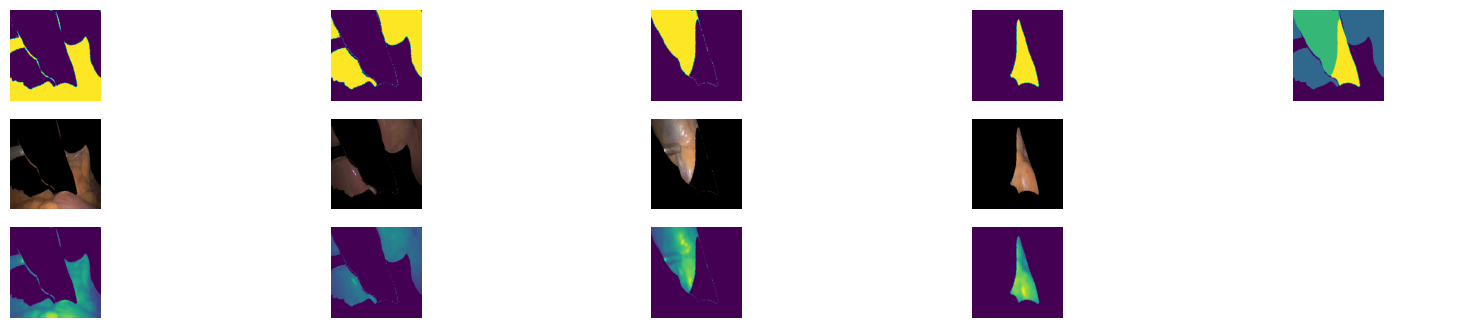

In [7]:
# Expert labels and masks
plt.clf()
fig, ax = plt.subplots(3, num_exp_groups+1, figsize=(4*(num_exp_groups+1), 4))

for a in ax:
    for _a in a:
        _a.set_axis_off()

for i in range(num_exp_groups):
    ax[0,i].imshow(exp_masks[i].numpy())
    ax[1,i].imshow(exp_masked_raw_image[i].numpy().transpose(1,2,0))
    ax[2,i].imshow(exp_masked_blr_image[i].numpy().transpose(1,2,0))

# Also check out the whole thing
ax[0,-1].imshow(exp_labels.numpy())

In [8]:
# Run quickshift group extraction
num_qs_groups = 6
qs_extractor = exlib.features.vision.QuickshiftGroups(max_groups=num_qs_groups)
qs_masks = qs_extractor(raw_image.unsqueeze(0))[0]
qs_labels = (torch.arange(qs_masks.size(0)).view(-1,1,1) * qs_masks).sum(dim=0)
qs_masked_raw_image = qs_masks.unsqueeze(1) * raw_image.unsqueeze(0) # (num_qs_groups, C, H, W)
qs_masked_blr_image = qs_masks.unsqueeze(1) * blr_image.unsqueeze(0) # (num_qs_groups, C, H, W)

<Figure size 640x480 with 0 Axes>

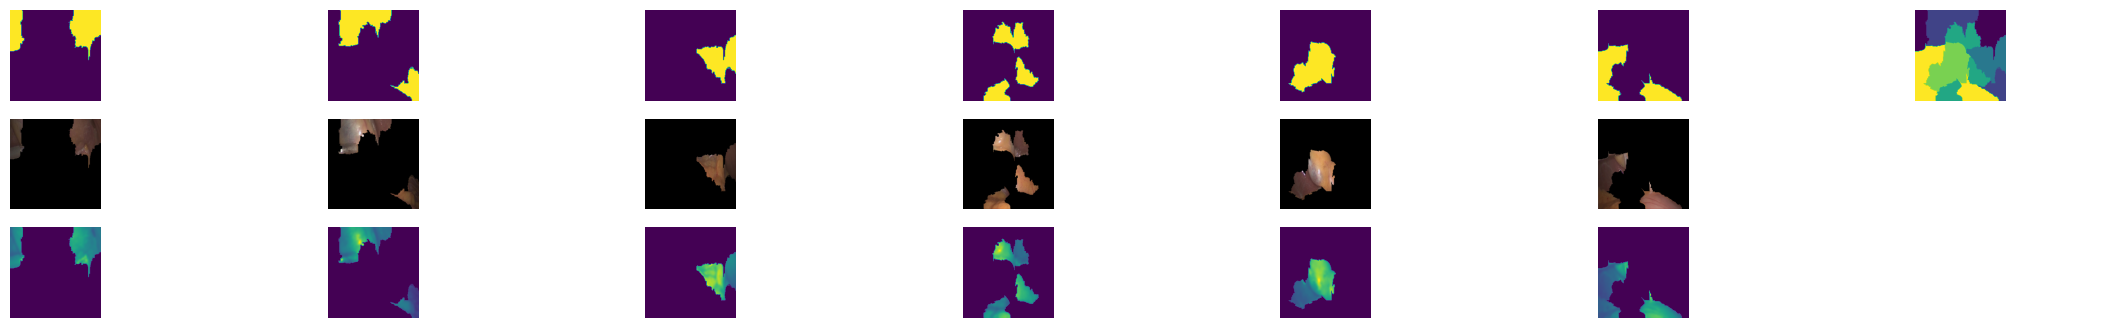

In [9]:
# Expert labels and masks
plt.clf()
fig, ax = plt.subplots(3, num_qs_groups+1, figsize=(4*(num_qs_groups+1), 4))

for a in ax:
    for _a in a:
        _a.set_axis_off()

for i in range(num_qs_groups):
    ax[0,i].imshow(qs_masks[i].numpy())
    ax[1,i].imshow(qs_masked_raw_image[i].numpy().transpose(1,2,0))
    ax[2,i].imshow(qs_masked_blr_image[i].numpy().transpose(1,2,0))

# Also check out the whole thing
ax[0,-1].imshow(qs_labels.numpy())

In [10]:
saveto_dir = "_dump/dont_vomit_haha/"

In [11]:
os.makedirs(saveto_dir, exist_ok=True)

In [12]:
torchvision.utils.save_image(raw_image, saveto_dir + "raw_image.png")
torchvision.utils.save_image(blr_image, saveto_dir + "blr_image.png")

In [13]:
for i in range(num_exp_groups):
    torchvision.utils.save_image(exp_masked_raw_image[i], saveto_dir + f"exp_raw_masked_{i}.png")
    torchvision.utils.save_image(exp_masked_blr_image[i], saveto_dir + f"exp_blr_masked_{i}.png")

In [14]:
for i in range(num_qs_groups):
    torchvision.utils.save_image(qs_masked_raw_image[i], saveto_dir + f"qs_raw_masked_{i}.png")
    torchvision.utils.save_image(qs_masked_blr_image[i], saveto_dir + f"qs_blr_masked_{i}.png")

In [15]:
for i in range(3):
    torchvision.utils.save_image(gng_masked_raw_image[i], saveto_dir + f"gng_raw_masked_{i}.png")
    torchvision.utils.save_image(gng_masked_blr_image[i], saveto_dir + f"gng_blr_masked_{i}.png")